# NLP with Disaster Tweets

## Problem Statement

The goal of this project is to develop a predictive model that accurately classifies tweets as related to real disasters (1) or not (0). Using the text of the tweets, keywords, and location data ( if they are available ) from the train.csv dataset, the model will be trained and then tested on the test.csv. The final predictions will be submitted in the format provided by sample_submission.csv. This model aims to improve real-time disaster monitoring on social media platforms like Twitter.

## Install packages and import libraries

### Install packages

In [32]:
!pip install kaggle
!pip install tensorflow

### Import libraries

In [2]:
import os

Prior to importing the KaggleApi library, it's necessary to set the environment variables for kaggle.

In [3]:
os.environ['KAGGLE_USERNAME'] = 'stevenli198802'
os.environ['KAGGLE_KEY'] = 'c03a09d2e6935fdf5b5b48840a522c5e'

In [34]:
import zipfile
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from kaggle.api.kaggle_api_extended import KaggleApi
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from sklearn.model_selection import GridSearchCV

## Download the data

Use the Kaggle API to download the dataset.

In [5]:
# Set up the Kaggle API
api = KaggleApi()
api.authenticate()

# Define the competition and dataset files
competition_name = 'nlp-getting-started'
files_to_download = ['train.csv', 'test.csv']

# Create a directory to store the dataset
os.makedirs('kaggle_data',exist_ok=True)

# Download the competition files
for file_name in files_to_download:
    api.competition_download_file(competition_name, file_name, path='kaggle_data')

# Load the dataset
train_data = pd.read_csv('kaggle_data/train.csv')
test_data = pd.read_csv('kaggle_data/test.csv')

train.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)


## EDA

### Check the basic information of the dataset

In [6]:
print(train_data.info())
print(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


### Handle the missing values

In [7]:
# Check the missing values
print(train_data.isnull().sum())
print(test_data.isnull().sum())

# fill the missing value with ''
train_data.fillna('', inplace=True)
test_data.fillna('', inplace=True)

# Check the missing values again
print(train_data.isnull().sum())
print(test_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
id             0
keyword       26
location    1105
text           0
dtype: int64
id          0
keyword     0
location    0
text        0
target      0
dtype: int64
id          0
keyword     0
location    0
text        0
dtype: int64


### Visualize target distribution

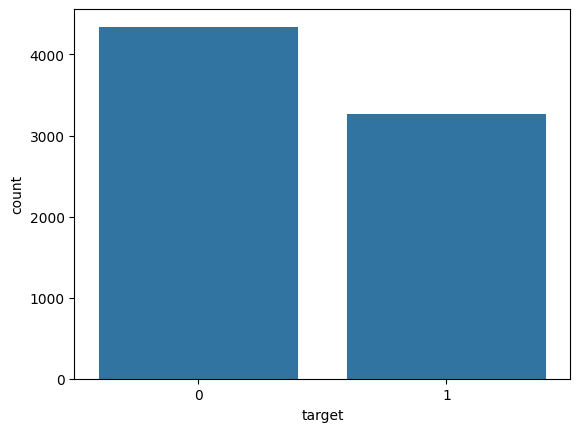

In [8]:
sns.countplot(x='target', data=train_data)
plt.show()

The dataset is not exactly balanced but totally it is good enough.

### Check some sample data.

In [9]:
print(train_data.head())
print(test_data.head())

   id keyword location                                               text  \
0   1                   Our Deeds are the Reason of this #earthquake M...   
1   4                              Forest fire near La Ronge Sask. Canada   
2   5                   All residents asked to 'shelter in place' are ...   
3   6                   13,000 people receive #wildfires evacuation or...   
4   7                   Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
   id keyword location                                               text
0   0                                  Just happened a terrible car crash
1   2                   Heard about #earthquake is different cities, s...
2   3                   there is a forest fire at spot pond, geese are...
3   9                            Apocalypse lighting. #Spokane #wildfires
4  11                       Typhoon Soudelor kills 28 in China and Taiwan


We need to clean the text to do our analysis.

## Data Preprocessing

### Clean the text data

#### Define text data cleanning functions

In [46]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Initialize the WordNet lemmatizer and stopwords
lematizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN

# Define a function to clean our text data
def clean_text(text):
  # Remove URLs
  text = re.sub(r'http\S+', '', text)
  # Remove non-alphanumeric characters
  text = re.sub(r'[^A-Za-z0-9\s]', '', text)
  # Convert text to lowercase
  text = text.lower()
  # Tokenize the text
  words = text.split()
  # Tag parts of speech
  tagged_words = pos_tag(words)
  # Lemmatize words based on their POS tags and remove stop words
  cleaned_words = [lematizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_words if word not in stop_words]
  # Join the cleaned words back into a single string
  cleaned_text = ' '.join(cleaned_words)
  return cleaned_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Apply text cleaning

In [52]:
train_data['text'] = train_data['text'].apply(clean_text)
test_data['text'] = test_data['text'].apply(clean_text)

print(train_data['text'].head())
print(test_data['text'].head())

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident ask shelter place notify officer evac...
3    13000 people receive wildfire evacuation order...
4    get send photo ruby alaska smoke wildfire pour...
Name: text, dtype: object
0                            happen terrible car crash
1    heard earthquake different city stay safe ever...
2    forest fire spot pond goose flee across street...
3                    apocalypse light spokane wildfire
4                typhoon soudelor kill 28 china taiwan
Name: text, dtype: object


### Tokenization and Padding

### Encoding labels

In [53]:
y_train = train_data['target'].values
X_train = train_data.drop(['target'], axis=1).values

print(y_train.shape)
print(X_train.shape)

(7613,)
(7613, 4)


In [54]:
placeholder_value = -1

# Add 1 for the padding token
unique_texts = train_data['text'].unique()

# Get the number of keywords
unique_keywords = train_data['keyword'].unique()

# Get the number of location
unique_locations = train_data['location'].unique()

# Tokenization for texts, keywords and locations
tokenizer_texts = Tokenizer(lower = True, oov_token='<OOV>')
tokenizer_texts.fit_on_texts(train_data['text'])
X_train_text = pad_sequences(tokenizer_texts.texts_to_sequences(train_data['text']))

tokenizer_keywords = Tokenizer(lower = True, oov_token='<OOV>')
tokenizer_keywords.fit_on_texts(train_data['keyword'])
X_train_keywords = pad_sequences(tokenizer_keywords.texts_to_sequences(train_data['keyword']), padding='post', value=placeholder_value)

tokenizer_locations = Tokenizer(lower = True,  oov_token='<OOV>')
tokenizer_locations.fit_on_texts(train_data['location'])
X_train_locations = pad_sequences(tokenizer_locations.texts_to_sequences(train_data['location']), padding='post', value=placeholder_value)

# Check if the data has been processed correctly
print("X_train_text:\n", X_train_text[:50])
print("X_train_keywords:\n", X_train_keywords[:50])
print("X_train_locations:\n", X_train_locations[:50])
print("y_train:\n", y_train.shape)

# Tokenization for text, keywords and locations for test dataset
tokenizer_texts_test = Tokenizer(lower = True, oov_token='<OOV>')
tokenizer_texts_test.fit_on_texts(test_data['text'])
X_test_text = pad_sequences(tokenizer_texts_test.texts_to_sequences(test_data['text']))

tokenizer_keywords_test = Tokenizer(lower = True, oov_token='<OOV>')
tokenizer_keywords_test.fit_on_texts(test_data['keyword'])
X_test_keywords = pad_sequences(tokenizer_keywords.texts_to_sequences(test_data['keyword']), padding='post', value=placeholder_value)

tokenizer_locations_test = Tokenizer(lower = True,  oov_token='<OOV>')
tokenizer_locations_test.fit_on_texts(test_data['location'])
X_test_locations = pad_sequences(tokenizer_locations.texts_to_sequences(test_data['location']), padding='post', value=placeholder_value)

# Check the shape of test dataset
print("X_test_text:\n", X_test_text.shape)
print("X_test_keywords:\n", X_test_keywords.shape)
print("X_test_locations:\n", X_test_locations.shape)

X_train_text:
 [[   0    0    0 ... 1372 2443    8]
 [   0    0    0 ... 5596 5597 1047]
 [   0    0    0 ...  376  329  414]
 ...
 [   0    0    0 ...  116  439  523]
 [   0    0    0 ...    0  232 2953]
 [   0    0    0 ...  224   31  362]]
X_train_keywords:
 [[-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [-1 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]
 [79 -1 -1]]
X_train_locations:
 [[  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   -1]
 [  -1   -1   -1   -1   -1   -1   -1   -1   -1   -1   

### Split the data

In [55]:
X_train_combined = np.concatenate([X_train_text, X_train_keywords, X_train_locations], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_combined, y_train, test_size=0.2, random_state=2024)

print(X_train.shape)
print(X_val.shape)

X_test = np.concatenate([X_test_text, X_test_keywords, X_test_locations], axis=1)
print(X_test.shape)

(6090, 40)
(1523, 40)
(3263, 37)


## Model Creation and Analysis

### Model Creation

I'll develop two LSTM models using distinct parameters, then I'll assess their performance and select the superior one.

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step


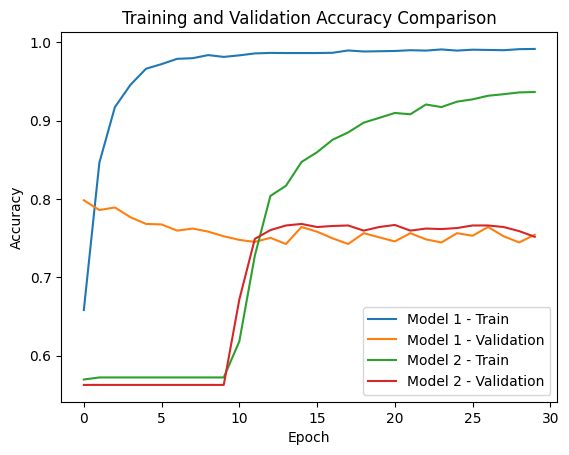

Model 1 - F1 Score: 0.719640179910045 Accuracy: 0.7544320420223244
Model 2 - F1 Score: 0.6931818181818182 Accuracy: 0.7518056467498359


In [39]:
# Define the first set of parameters
embedding_dim_1 = 128
lstm_units_1 = 100
dropout_rate_1 = 0.2
learning_rate_1 = 0.001

# Define the second set of parameters
embedding_dim_2 = 256
lstm_units_2 = 150
dropout_rate_2 = 0.3
learning_rate_2 = 0.01

vocab_size = len(tokenizer_texts.word_index) + 1
max_sequence_length = X_train_text.shape[1]

# Define the first LSTM model with the first set of parameters
def create_lstm_model_1():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_1))
    model.add(SpatialDropout1D(dropout_rate_1))
    model.add(LSTM(units=lstm_units_1, dropout=dropout_rate_1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate_1), metrics=['accuracy'])
    return model

# Define the second LSTM model with the second set of parameters
def create_lstm_model_2():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim_2))
    model.add(SpatialDropout1D(dropout_rate_2))
    model.add(LSTM(units=lstm_units_2, dropout=dropout_rate_2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=learning_rate_2), metrics=['accuracy'])
    return model

# Train and evaluate the first LSTM model
lstm_model_1 = create_lstm_model_1()
history_1 = lstm_model_1.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)
y_prob_1 = lstm_model_1.predict(X_val)
y_pred_1 = (y_prob_1 > 0.5).astype(int)
f1_score_1 = f1_score(y_val, y_pred_1)
accuracy_1 = accuracy_score(y_val, y_pred_1)

# Train and evaluate the second LSTM model
lstm_model_2 = create_lstm_model_2()
history_2 = lstm_model_2.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=0)
y_prob_2 = lstm_model_2.predict(X_val)
y_pred_2 = (y_prob_2 > 0.5).astype(int)
f1_score_2 = f1_score(y_val, y_pred_2)
accuracy_2 = accuracy_score(y_val, y_pred_2)

# Plot the training and validation accuracy for the two models
plt.plot(history_1.history['accuracy'], label='Model 1 - Train')
plt.plot(history_1.history['val_accuracy'], label='Model 1 - Validation')
plt.plot(history_2.history['accuracy'], label='Model 2 - Train')
plt.plot(history_2.history['val_accuracy'], label='Model 2 - Validation')
plt.title('Training and Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Compare the F1 scores and accuracy of the two models
print("Model 1 - F1 Score:", f1_score_1, "Accuracy:", accuracy_1)
print("Model 2 - F1 Score:", f1_score_2, "Accuracy:", accuracy_2)


### Analysis

We can note that there is not a significant difference in performance between the two models. While the training accuracy of Model 2 increases with the number of epochs, its validation accuracy decreases. Therefore, I have decided to use Model 1 to make predictions on our test dataset.

## Prediction on our test dataset


In [63]:
test_ids = test_data['id'].values
y_test_pred = lstm_model_1.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int).flatten()

print(test_ids.shape)
print(y_test_pred.shape)

df = pd.DataFrame({'id': test_ids, 'target': y_test_pred})
df.to_csv('submission.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
(3263,)
(3263,)


Once uploading the submission.csv file to kaggle, we can get the result here.
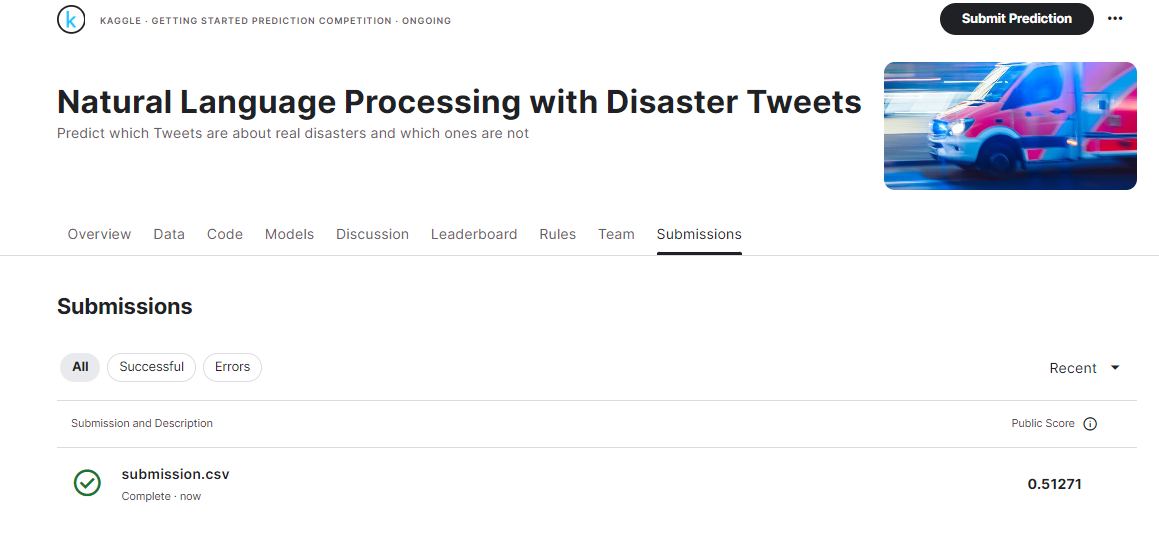

Since it's not very good score, let's try with model2.

In [64]:
y_test_pred_2 = lstm_model_2.predict(X_test)
y_test_pred_2 = (y_test_pred > 0.5).astype(int).flatten()

df = pd.DataFrame({'id': test_ids, 'target': y_test_pred_2})
df.to_csv('submission_2.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step


We can see the score is exactly the same.
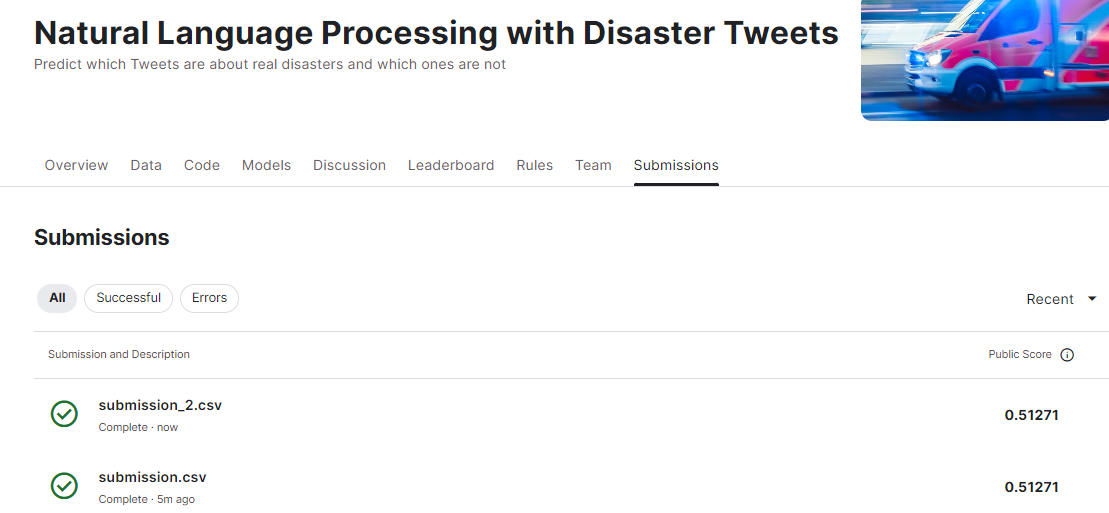

## Conclusion

We preprocess the data, clean the text, and create two LSTM models. Although the final score is not very high, it serves as good practice.